In [1]:
import pickle as pkl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyeasyfi.data.load_data import get_data_from_cb
from pyeasyfi.utils.utils import  get_top_n_cryptos
from pyeasyfi.utils.fin import compute_log_returns, compute_returns
from pyeasyfi.risks.asset.volatility import compute_historical_volatility, compute_GARCH_volatility
from pyeasyfi.risks.asset.value_at_risk import compute_historical_VaR, compute_var_covar_VaR, compute_montecarlo_VaR
from pyeasyfi.utils.simulation_kernels.random_walk import RandomWalkSimulation


In [2]:
"""
crypto_list = get_top_n_cryptos(8)
data = get_data_from_cb(crypto_list, start_date='2021-06-01-00-00', end_date='2024-07-01-00-00', granularity=3600)
data.to_parquet("./historical_data.parquet")
data
"""

'\ncrypto_list = get_top_n_cryptos(8)\ndata = get_data_from_cb(crypto_list, start_date=\'2021-06-01-00-00\', end_date=\'2024-07-01-00-00\', granularity=3600)\ndata.to_parquet("./historical_data.parquet")\ndata\n'

In [3]:
data = pd.read_parquet("historical_data.parquet")


# We separate Cryptos

In [4]:
cryptos = set(data["crypto"])
data_dict = dict()

for crypto in cryptos : 
    data_dict[crypto] = data[data["crypto"] == crypto]

In [5]:
data_dict["BTC"]

,low,high,open,close,volume,crypto
time,,,,,,
2021-06-01 00:00:00,37140.92,37918.97,37276.23,37849.85,1382.050493,BTC
2021-06-01 01:00:00,37170.07,37831.06,37831.06,37200.52,632.492777,BTC
2021-06-01 02:00:00,36636.47,37300.00,37200.52,36860.57,647.014915,BTC
2021-06-01 03:00:00,36500.00,37139.33,36856.82,36714.69,555.584683,BTC
2021-06-01 04:00:00,36572.97,36956.48,36714.69,36753.45,331.339400,BTC
...,...,...,...,...,...,...
2024-06-30 20:00:00,61876.55,62300.00,61926.69,61888.93,277.524789,BTC
2024-06-30 21:00:00,61728.10,61921.79,61886.94,61828.03,123.826867,BTC
2024-06-30 22:00:00,61821.87,62850.00,61828.03,62793.77,679.187125,BTC


# Risk computation

## Compute volatility

In [6]:
# Historical Volatility
log_returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_log_returns(value["close"])
    volatility = compute_historical_volatility(log_returns_dict[key])
    print(f"Volatility for {key} : {volatility}")


Volatility for DOGE : 0.9669570100767776
Volatility for USDT : 0.007052450582130323
Volatility for ETH : 0.7219536134327189
Volatility for SOL : 1.102453537711951
Volatility for BTC : 0.5849327443882928
Volatility for XRP : 0.5746828326182557


In [7]:
# ARCH Volatility
arch_log_returns_dict = dict()
for key, value in data_dict.items() :
    arch_log_returns_dict[key] = compute_log_returns(value["close"])
    volatility, model = compute_GARCH_volatility(arch_log_returns_dict[key]) # Auto manage rescaling
    print(f"Volatility for {key} : {volatility}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1835.2107355194007
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
Volatility for DOGE : 0.7395971805395661
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -7507.498287218492
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Volatility for USDT : 0.007345798532811125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2160.626158312822
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
Volatility for ETH : 0.5171293041117747
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1670.8711132354301
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Volatility for SOL : 0.970427842703012
Opt

/home/jean-marc/anaconda3/envs/streamlit/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00256. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/jean-marc/anaconda3/envs/streamlit/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.362e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/jean-marc/anaconda

## Test Random Walk MonteCarlo simulation

In [8]:
list(data_dict["DOGE"]['close'])[-1]

0.12473

#### On Log returns

In [9]:
returns = compute_log_returns(data_dict["DOGE"]["close"])
simulator  = RandomWalkSimulation(returns, list(data_dict["DOGE"]['close'])[-1])
sim_results = simulator.run(150)
sim_results

,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,sim_10,...,sim_141,sim_142,sim_143,sim_144,sim_145,sim_146,sim_147,sim_148,sim_149,sim_150
0,0.123509,0.129263,0.121478,0.122323,0.118420,0.122690,0.118604,0.120596,0.128017,0.119090,...,0.114874,0.121526,0.140072,0.134107,0.133350,0.118035,0.119842,0.120830,0.135263,0.127895
1,0.115249,0.129675,0.116172,0.119894,0.114441,0.116202,0.119149,0.125293,0.127477,0.107221,...,0.110061,0.123320,0.131777,0.143881,0.136804,0.112148,0.127313,0.120445,0.136023,0.130392
2,0.104820,0.125831,0.129635,0.119041,0.112565,0.116280,0.121207,0.130068,0.131688,0.106195,...,0.123965,0.127285,0.132608,0.145500,0.142595,0.103481,0.129182,0.129020,0.131779,0.134373
3,0.109050,0.127214,0.115387,0.118670,0.099454,0.123856,0.140044,0.123032,0.121721,0.104185,...,0.119933,0.126666,0.138887,0.148151,0.149692,0.097621,0.131914,0.139571,0.124576,0.135297
4,0.102843,0.126706,0.111897,0.120762,0.092175,0.125158,0.131705,0.117222,0.128481,0.104881,...,0.122946,0.132010,0.151373,0.133363,0.141205,0.102230,0.134567,0.140910,0.125119,0.136948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.134683,0.083291,0.102302,0.090665,0.052554,0.113930,0.101380,0.328738,0.099570,0.020303,...,0.104700,0.031366,0.061642,0.053975,0.087970,0.141469,0.108266,0.076919,0.015553,0.038075
361,0.135797,0.077289,0.096906,0.090992,0.054438,0.111041,0.107013,0.308661,0.103631,0.019849,...,0.103290,0.029985,0.062363,0.057830,0.085958,0.124370,0.121784,0.077942,0.017531,0.039282
362,0.146038,0.076815,0.095450,0.092503,0.052151,0.103407,0.100227,0.296308,0.106662,0.019415,...,0.101769,0.030267,0.064164,0.059619,0.073813,0.126694,0.113042,0.078222,0.017336,0.037887
363,0.157341,0.073620,0.094970,0.097069,0.049966,0.102544,0.104684,0.303429,0.105747,0.018870,...,0.094226,0.028993,0.058030,0.056836,0.070608,0.130872,0.116928,0.077966,0.017603,0.037407


<Axes: >

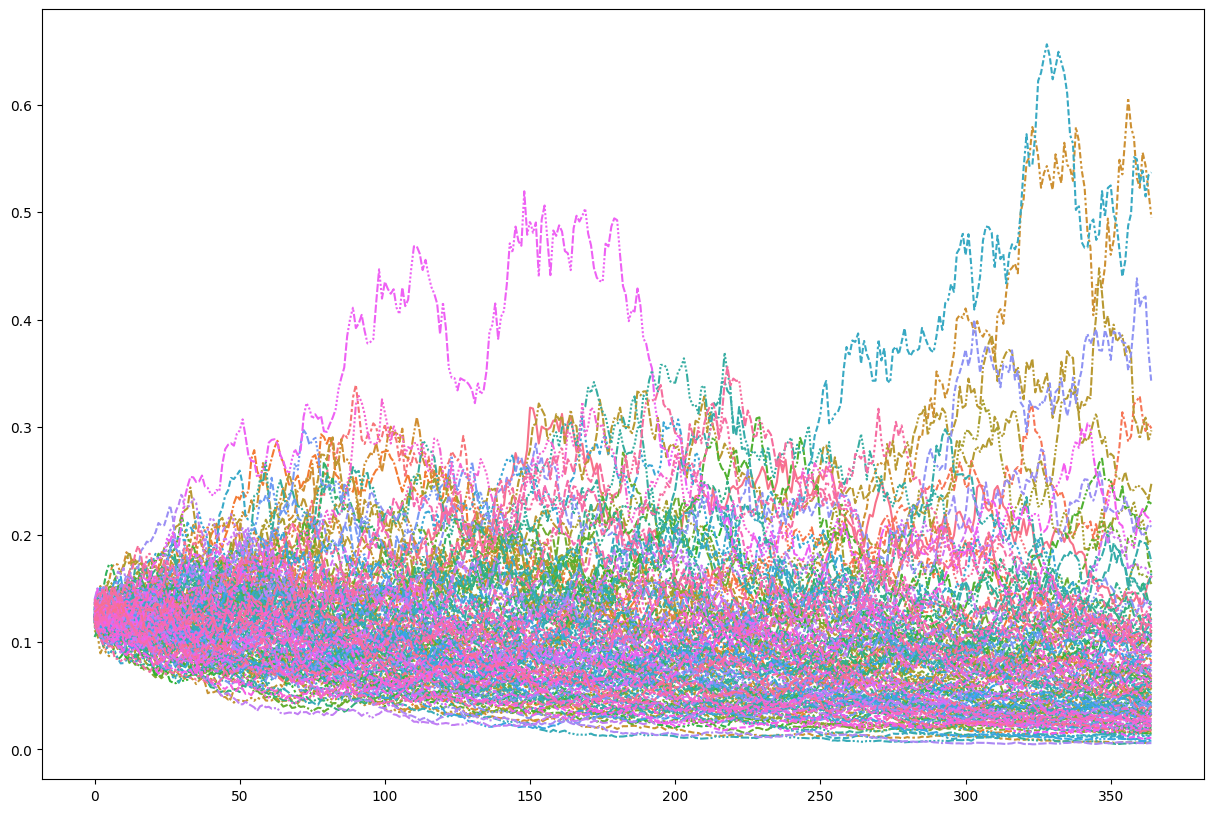

In [10]:
plt.figure(figsize=(15,10))
sns.lineplot(sim_results, legend=False)

#### On returns

In [11]:
returns = compute_returns(data_dict["DOGE"]["close"])
simulator  = RandomWalkSimulation(returns, list(data_dict["DOGE"]['close'])[-1]) #shouldn't use on normal returns
sim_results = simulator.run(150)
sim_results

,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,sim_10,...,sim_141,sim_142,sim_143,sim_144,sim_145,sim_146,sim_147,sim_148,sim_149,sim_150
0,1.142290e-03,6.614664e-11,5.234083e-06,5.458636e-06,3.087674e-03,7.561123e-07,1.431870e-10,9.866381e-08,3.740563e-09,1.316262e-04,...,4.215590e-09,7.085436e-09,8.455336e-11,6.701965e-10,1.225932e-04,2.492263e-07,1.295723e-07,4.963728e-09,5.599768e-08,2.981789e-09
1,7.226635e-09,6.579940e-17,2.023431e-10,1.524507e-09,2.785211e-12,4.676985e-10,3.429302e-18,3.591336e-17,1.380347e-13,1.524152e-07,...,2.290619e-13,9.055588e-12,2.827825e-21,1.150621e-15,1.538074e-13,1.368827e-09,1.866908e-13,2.481915e-17,9.375519e-16,2.417927e-15
2,2.935007e-12,2.489372e-23,3.265376e-17,1.635174e-12,4.190036e-17,7.349105e-14,3.426504e-24,3.070049e-22,9.230537e-20,3.371727e-12,...,2.356673e-20,7.226849e-15,1.187807e-25,5.983175e-23,2.894339e-17,2.857535e-17,3.460304e-19,7.826311e-22,4.567977e-21,4.438419e-21
3,1.212389e-16,1.521558e-30,8.839710e-22,3.701928e-18,5.594406e-21,1.865059e-21,3.059179e-31,1.715344e-26,6.635287e-27,9.280123e-15,...,1.571867e-22,3.280773e-17,6.718804e-33,4.710926e-29,2.250761e-22,1.790608e-23,2.309525e-23,4.628731e-30,1.230549e-25,7.913520e-27
4,7.104845e-20,2.016458e-38,2.208353e-27,5.738520e-27,1.462561e-29,1.382150e-29,4.959594e-38,5.684369e-33,1.213170e-35,2.152281e-22,...,3.896899e-26,1.340924e-20,1.641115e-36,1.933120e-39,1.903145e-26,7.746796e-29,1.398109e-25,2.727149e-35,4.691015e-33,7.052906e-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
361,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
362,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
363,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


<Axes: >

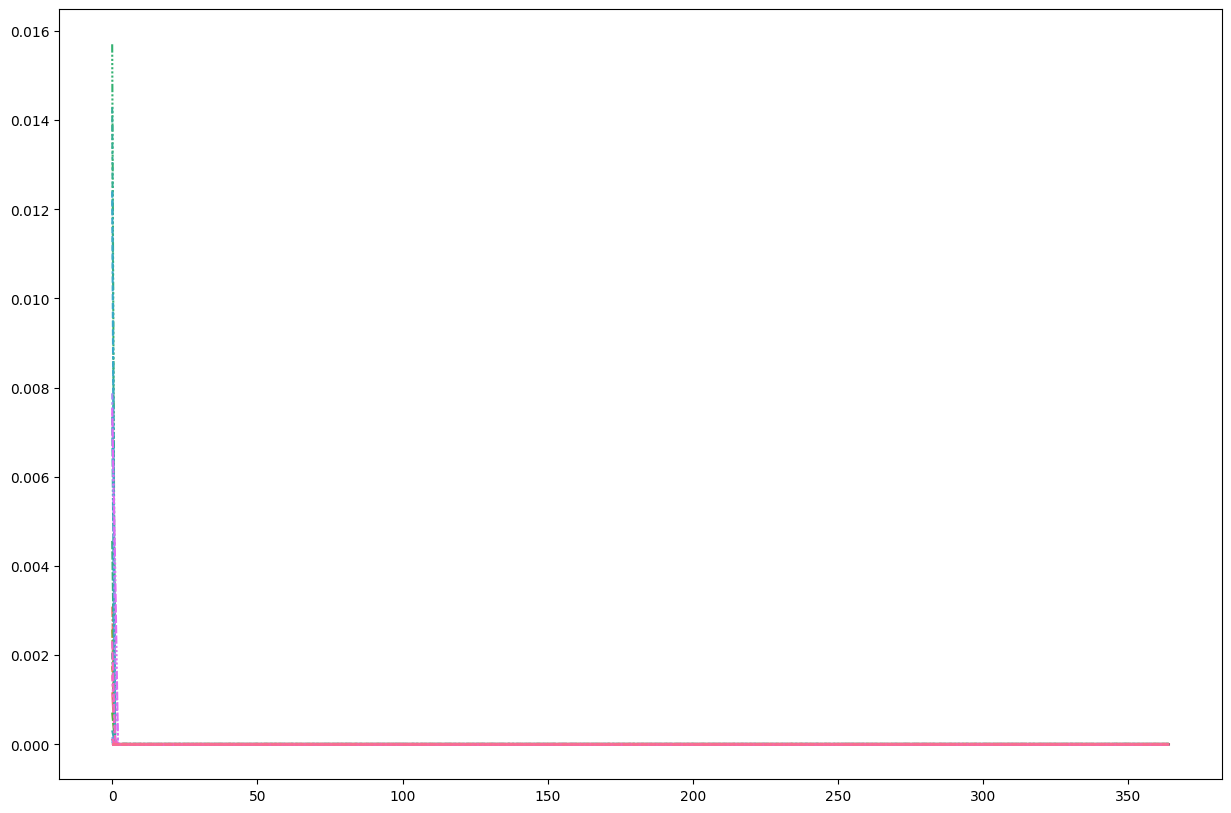

In [12]:
plt.figure(figsize=(15,10))
sns.lineplot(sim_results, legend=False)

## Compute Value At Risk

In [13]:
# Historical VaR
returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_returns(value["close"])
    var = compute_historical_VaR(log_returns_dict[key])
    print(f"Value at risk for {key} : {var}")

Value at risk for DOGE : -7.278290647656764
Value at risk for USDT : -0.042004725815977806
Value at risk for ETH : -6.161158608918638
Value at risk for SOL : -8.28361922220767
Value at risk for BTC : -4.720670457190191
Value at risk for XRP : -4.524782378479985


In [14]:
# Variance covariance VAR
returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_returns(value["close"])
    var = compute_var_covar_VaR(log_returns_dict[key])
    print(f"Value at risk for {key} : {var}")

Value at risk for DOGE : -8.359920373840474
Value at risk for USDT : -0.060807520285878394
Value at risk for ETH : -6.100544229610936
Value at risk for SOL : -9.132256875995385
Value at risk for BTC : -4.928948123653993
Value at risk for XRP : -5.0344351683428075


In [18]:
# Variance covariance VAR --> this is 95 annual loss en pct
returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_log_returns(value["close"])
    var = compute_montecarlo_VaR(log_returns_dict[key], start_price=value['close'][-1], n_simulations=100000, horizon=365)
    print(f"Value at risk for {key} : {var}")

Value at risk for DOGE : -91.23900690646748
Value at risk for USDT : -1.1930384648233345
Value at risk for ETH : -74.07888687016977
Value at risk for SOL : -86.19621479891138
Value at risk for BTC : -61.39956531808534
Value at risk for XRP : -81.07857698749717
